This notebooks contains code to generate figure 5: comparing different libraries for different genes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

from os import listdir
# import isfile
from os.path import isfile

# load the matplot lib plotting style
plt.style.use('/data/davidding/dms/dms_plants/src/paper_style1.mplstyle')

# load arial.ttf font from file
import matplotlib.font_manager as font_manager
font_path = '/data/davidding/dms/dms_plants/src/Arial.ttf'
#font_prop = font_manager.FontProperties(fname=font_path)

mpl.font_manager.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Arial'

import importlib

import sys
sys.path.append('../src/')
import plotting as pt
import nucleotides as nt
from constants import sample_to_positions

dout = '/data/davidding/dms/plots/fig5/'

din_lr = '/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/'
din_raw = '/data/davidding/dms/illumina_data/data/clean/illumina/lrr_rcs_rescaled/'

psbs_col = '#c0bfff'
raf1_col = '#b7e6ff'
sbpase_col = '#ff8eaa'

In [33]:
def get_sig_confident_oe_df(df):
    return df.loc[
        (df['pval'] < 0.05/len(df)) &
        (df['mean_lrr_observed_reads'] > 1.5) &
        (df['beta'] >1.5)
    ]
din_lr = '/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/'
din_raw = '/data/davidding/dms/illumina_data/data/clean/illumina/lrr_rcs_rescaled/'

df_din_psbs = pd.read_csv(din_lr +'3C_sorghum_mean_lrr_lr.csv')
df_din_psbs_sig = get_sig_confident_oe_df(df_din_psbs)

df_din_raf1= pd.read_csv(din_lr +'3B_sorghum_mean_lrr_lr.csv')
df_din_raf1_sig = get_sig_confident_oe_df(df_din_raf1)
df_din_sbpase= pd.read_csv(din_lr +'3A_sorghum_mean_lrr_lr.csv')
df_din_sbpase_sig = get_sig_confident_oe_df(df_din_sbpase)


# Add mutation type columns to each DataFrame
def add_mutation_type_column(df):
    """Add a mutation_type column based on the 'mut' column patterns"""
    df = df.copy()  # Don't modify original DataFrame
    
    # Classify mutations based on patterns in 'mut' column
    conditions = [
        df.mut.str.contains('I', na=False),  # Insertions
        df.mut.str.contains('_', na=False),  # Deletions
    ]
    choices = ['insertion', 'deletion']
    
    # Everything else is substitution
    df['mutation_type'] = np.select(conditions, choices, default='substitution')
    
    return df

# Apply mutation type classification to each DataFrame
df_din_psbs_sig_with_type = add_mutation_type_column(df_din_psbs_sig)
df_din_raf1_sig_with_type = add_mutation_type_column(df_din_raf1_sig)
df_din_sbpase_sig_with_type = add_mutation_type_column(df_din_sbpase_sig)

# Create dictionary mapping gene names to DataFrames
gene_mutation_data = {
    'PsbS': df_din_psbs_sig_with_type,
    'Raf1': df_din_raf1_sig_with_type,
    'SBPase': df_din_sbpase_sig_with_type
}

# panel a  rolling average all mutations

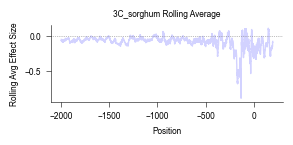

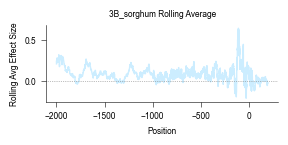

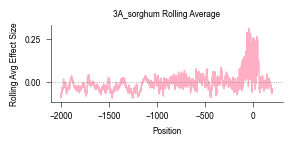

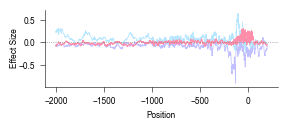

In [ ]:
def plot_rolling_average_all_genes(
        genes=['3C_sorghum', '3B_sorghum', '3A_sorghum'], 
        window_size=50,
        figsize=(9, 3),
        fs=6,
        colors=['blue', 'red', 'green'],
        din_lr='/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/',
        dout='/data/davidding/dms/plots/fig2/',
        save_individual=True,
        save_combined=True
    ):
    """
    Plot rolling averages for all three genes, both individually and combined.
    
    genes: list of gene names
    window_size: rolling window size
    figsize: figure size
    fs: font size
    colors: list of colors for each gene
    din_lr: input directory path
    dout: output directory path
    save_individual: whether to save individual plots
    save_combined: whether to save combined plot
    """
    
    # Individual plots
    if save_individual:
        for i, gene in enumerate(genes):
            # Load data
            df_lr = pd.read_csv(din_lr + gene + '_mean_lrr_lr.csv')
            df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)

            # get 5'-UTR length
            gene_id = gene.split('_')[0]
            len_utr = sample_to_positions[gene_id][2] - sample_to_positions[gene_id][1]

            df_lr_plots = df_lr.loc[(df_lr.pos > -2001) & (df_lr.pos < len_utr)]
            
            # Plot individual rolling average
            plot_rolling_average_effect_stats(
                df_lr_plots, 
                window_size=window_size, 
                position_col='pos', 
                effect_col='beta', 
                figsize=(3,1), 
                fs=fs,
                color=colors[i % len(colors)],
                gene_name=gene,
                fout=dout + f'{gene}_rolling_avg_beta_w{window_size}.png'
            )
    
    # Combined plot
    if save_combined:
        plt.figure(figsize=figsize)
        
        for i, gene in enumerate(genes):
            # Load data
            df_lr = pd.read_csv(din_lr + gene + '_mean_lrr_lr.csv')
            df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)
            # get 5'-UTR length
            gene_id = gene.split('_')[0]
            len_utr = sample_to_positions[gene_id][2] - sample_to_positions[gene_id][1]
            print(f'Gene: {gene}, 5\'-UTR length: {len_utr}, {sample_to_positions[gene_id][2]}, {sample_to_positions[gene_id][1]}')
            df_lr_plots = df_lr.loc[(df_lr.pos > -2001) & (df_lr.pos < len_utr)]
            
            # Sort and clean data
            df_sorted = df_lr_plots.sort_values('pos').copy()
            df_clean = df_sorted.dropna(subset=['pos', 'beta'])
            
            # Calculate rolling average
            df_clean['rolling_avg'] = df_clean['beta'].rolling(window=window_size, center=True, min_periods=1).mean()
            
            # Plot
            plt.plot(df_clean['pos'], df_clean['rolling_avg'], 
                     color=colors[i % len(colors)], alpha=0.8, linewidth=0.3, 
                     label=f'{gene} (window={window_size})')
        
        # Add horizontal line at y=0
        plt.axhline(0, color='gray', linestyle='dotted', lw=0.5)
        
        # Make axes and ticks thinner
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(0.4)
        plt.tick_params(width=0.4)
        
        plt.xticks(list(range(-2000, 300, 100)), labels = [x if x%500==0 else '' for x in list(range(-2000, 300, 100))], fontsize=fs)

        plt.yticks(fontsize=fs)
        plt.xlabel('Position', fontsize=fs)
        plt.ylabel('Effect Size', fontsize=fs, labelpad=0)
        #plt.title('Rolling Average Comparison', fontsize=fs)
        #plt.legend(fontsize=fs-1)
        
        # Save combined plot
        plt.savefig(dout + f'all_genes_rolling_avg_beta_w{window_size}.png', dpi=500, bbox_inches="tight")
        plt.savefig(dout + f'all_genes_rolling_avg_beta_w{window_size}.svg', format='svg', bbox_inches="tight")
        plt.show()

# Example usage with the same data paths as the existing code
plot_rolling_average_all_genes(
    genes=['3C_sorghum', '3B_sorghum', '3A_sorghum'],
    window_size=70,
    figsize=(3, 1),
    fs=6,
    colors=[psbs_col, raf1_col, sbpase_col],  # Blue, orange, green
    din_lr=din_lr,
    dout=dout,
    save_individual=True,
    save_combined=True
)

# b: deletion comparions


Creating deletion heatmap...


/tmp/ipykernel_2855432/594864042.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_obj = plt.cm.get_cmap(cmap).copy()
/tmp/ipykernel_2855432/594864042.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))
/tmp/ipykernel_2855432/594864042.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Processing 3C_sorghum deletions...
  Found 406 deletions for 3C_sorghum
Processing 3B_sorghum deletions...


/tmp/ipykernel_2855432/594864042.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))
/tmp/ipykernel_2855432/594864042.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))


  Found 220 deletions for 3B_sorghum
Processing 3A_sorghum deletions...
  Found 434 deletions for 3A_sorghum


/tmp/ipykernel_2855432/594864042.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))


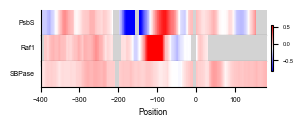

In [ ]:
def plot_deletion_heatmap_proper_rows(
    genes=["3C_sorghum", "3B_sorghum", "3A_sorghum"],
    window_size=25,
    position_range=(-400, 200),
    del_length_range=(10, 15),
    figsize=(12, 2),
    fs=8,
    cmap='RdBu_r',
    gene_labels=None,
    din_lr="/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/",
    dout="/data/davidding/dms/plots/fig2/",
    fout=None
):
    """
    Plot heatmap with proper 3 separate rows showing rolling average effects for deletions.
    
    genes: list of gene names
    window_size: rolling window size
    position_range: tuple of (min_pos, max_pos) 
    del_length_range: tuple of (min_length, max_length) for deletion filtering
    figsize: figure size
    fs: font size
    cmap: colormap for heatmap
    gene_labels: dictionary mapping gene names to display labels (optional)
    din_lr: input directory path
    dout: output directory path
    fout: output filename (optional)
    """
    
    # Create figure with 3 subplots stacked vertically
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    fig.subplots_adjust(hspace=0)  # Remove space between subplots
    
    # Define position bins for consistent x-axis
    min_pos, max_pos = position_range
    pos_bins = np.arange(min_pos, max_pos + 1, 5)  # 5 bp resolution for smoother visualization
    
    all_effects = []  # To determine global color scale
    
    # Set up colormap to show NaN values as grey
    cmap_obj = plt.cm.get_cmap(cmap).copy()
    cmap_obj.set_bad('lightgrey', 1.0)
    
    # First pass: collect all data to determine color scale
    for i, gene in enumerate(genes):
        df_lr = pd.read_csv(din_lr + gene + '_mean_lrr_lr.csv')
        df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)
        df_lr['mut_type'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[2] if x != 'wt' else np.nan)
        
        df_lr_dels = df_lr.loc[df_lr.mut.str.contains('_', na=False)]
        df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))
        
        df_lr_dels_core = df_lr_dels.loc[(df_lr_dels.pos > min_pos) & (df_lr_dels.pos < max_pos)]
        df_lr_dels_core_small = df_lr_dels_core.loc[
            (df_lr_dels_core.del_length < del_length_range[1]) & 
            (df_lr_dels_core.del_length > del_length_range[0])
        ]
        
        if len(df_lr_dels_core_small) > 0:
            all_effects.extend(df_lr_dels_core_small['beta'].dropna().values)
    
    # Determine global color scale
    if len(all_effects) > 0:
        vmin, vmax = np.percentile(all_effects, [5, 95])
    else:
        vmin, vmax = -1, 1
    
    # Second pass: create heatmaps
    for i, gene in enumerate(genes):
        print(f"Processing {gene} deletions...")
        
        df_lr = pd.read_csv(din_lr + gene + '_mean_lrr_lr.csv')
        df_lr['pos'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)
        df_lr['mut_type'] = df_lr.mut.apply(lambda x: nt.break_mut(x)[2] if x != 'wt' else np.nan)
        
        df_lr_dels = df_lr.loc[df_lr.mut.str.contains('_', na=False)]
        df_lr_dels['del_length'] = df_lr_dels.mut.apply(lambda x: len(nt.break_mut(x)[2]))
        
        df_lr_dels_core = df_lr_dels.loc[(df_lr_dels.pos > min_pos) & (df_lr_dels.pos < max_pos)]
        df_lr_dels_core_small = df_lr_dels_core.loc[
            (df_lr_dels_core.del_length < del_length_range[1]) & 
            (df_lr_dels_core.del_length > del_length_range[0])
        ]
        
        print(f"  Found {len(df_lr_dels_core_small)} deletions for {gene}")
        
        if len(df_lr_dels_core_small) > 0:
            # Sort by position and calculate rolling average
            df_sorted = df_lr_dels_core_small.sort_values('pos').copy()
            df_clean = df_sorted.dropna(subset=['pos', 'beta'])
            
            if len(df_clean) >= window_size:
                df_clean['rolling_avg'] = df_clean['beta'].rolling(
                    window=window_size, center=True, min_periods=1
                ).mean()
            else:
                df_clean['rolling_avg'] = df_clean['beta']
            
            # Create binned data for heatmap
            binned_effects = []
            for pos in pos_bins:
                nearby_data = df_clean[abs(df_clean['pos'] - pos) <= 2.5]  # ±2.5 bp window
                if len(nearby_data) > 0:
                    binned_effects.append(nearby_data['rolling_avg'].mean())
                else:
                    binned_effects.append(np.nan)
            
            # Reshape for heatmap (single row)
            heatmap_row = np.array(binned_effects).reshape(1, -1)
            
        else:
            # If no data, create array of NaNs
            heatmap_row = np.full((1, len(pos_bins)), np.nan)
        
        # Plot heatmap for this gene
        im = axes[i].imshow(heatmap_row, 
                           aspect='auto', 
                           cmap=cmap_obj, 
                           extent=[min_pos, max_pos, -0.5, 0.5],
                           vmin=vmin, vmax=vmax)
        
        # Determine label for this gene
        if gene_labels is not None and gene in gene_labels:
            label = gene_labels[gene]
        else:
            label = gene
        
        # Format each subplot
        axes[i].set_ylabel(label, fontsize=fs-1, rotation=0, ha='right', va='center')
        axes[i].set_ylim(-0.5, 0.5)
        axes[i].set_yticks([])  # Remove y-ticks
        
        # Only show x-axis labels on bottom subplot
        if i < len(genes) - 1:
            axes[i].set_xticks([])
        else:
            x_ticks = np.arange(min_pos, max_pos + 1, 100)
            axes[i].set_xticks(x_ticks)
            axes[i].set_xlabel('Position', fontsize=fs)
            axes[i].tick_params(axis='x', labelsize=fs-1)
    
    # Add colorbar to the right
    cbar = fig.colorbar(im, ax=axes, shrink=0.6, pad=0.02)
    cbar.ax.tick_params(labelsize=fs-2)
    
    # Save if filename provided
    if fout is not None:
        plt.savefig(fout, dpi=500, bbox_inches="tight")
    elif dout is not None:
        plt.savefig(dout + f'deletion_heatmap_rows_w{window_size}.png', dpi=500, bbox_inches="tight")
    
    plt.show()



# Create deletion heatmap with custom labels
print("\nCreating deletion heatmap...")
plot_deletion_heatmap_proper_rows(
    genes=["3C_sorghum", "3B_sorghum", "3A_sorghum"],
    window_size=25,
    position_range=(-400, 180),
    del_length_range=(10, 15),
    figsize=(3.5,1),
    fs=6,
    cmap='bwr',
    gene_labels={'3A_sorghum': 'SBPase', '3B_sorghum': 'Raf1', '3C_sorghum': 'PsbS'},
    din_lr=din_lr,
    dout=dout
)

# c: top insertion by position

/tmp/ipykernel_2988486/3854523991.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_din_psbs_ins['pos'] = df_din_psbs_ins.mut.apply(lambda x: nt.break_mut(x)[1])
/tmp/ipykernel_2988486/3854523991.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_din_psbs_ins['pos'] = df_din_psbs_ins.mut.apply(lambda x: nt.break_mut(x)[1])
/tmp/ipykernel_2988486/3854523991.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

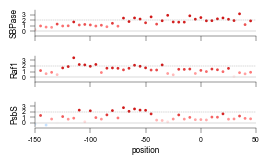

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src/')
import nucleotides as nt
from matplotlib.colors import LinearSegmentedColormap

# Load the matplotlib plotting style
plt.style.use('/data/davidding/dms/dms_plants/src/paper_style1.mplstyle')

# Load arial.ttf font from file
import matplotlib.font_manager as font_manager
import matplotlib as mpl
font_path = '/data/davidding/dms/dms_plants/src/Arial.ttf'
mpl.font_manager.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Arial'

# Set paths
din_lr = '/data/davidding/dms/illumina_data/linreg_all/scaled_coeffs/'
dout = '/data/davidding/dms/plots/fig3/'

def get_position_ins_max_effect(fin):
    df_din_psbs = pd.read_csv(din_lr + fin)
    # get all the insertions
    df_din_psbs_ins = df_din_psbs.loc[df_din_psbs.mut.str.startswith('I')]
    df_din_psbs_ins['pos'] = df_din_psbs_ins.mut.apply(lambda x: nt.break_mut(x)[1])
    # filter for positions in the inserted region
    df_din_psbs_ins_window = df_din_psbs_ins.loc[(df_din_psbs_ins.pos.astype(int) < 50) & 
                                                 (df_din_psbs_ins.pos.astype(int) > -151)]
    # filter for positions that are multiples of 5, ie. where we inserted
    df_defined = df_din_psbs_ins_window.loc[df_din_psbs_ins_window.pos.astype(int) % 5 == 0]
    df_pos_max = df_defined.groupby('pos').max()
    df_pos_count = df_defined.groupby('pos').count()
    return df_pos_max, df_pos_count

def plot_combined_insertion_effects():
    """Create a combined plot with 3 subplots for the three genes"""

    # Set up the figure with 3 subplots sharing x-axis
    fig, axes = plt.subplots(3, 1, figsize=(2.8, 1.75), sharex=True)
    fig.subplots_adjust(hspace=0.01)  # Reduce space between subplots

    # Gene data
    genes = [
        {"name": "SBPase", "file": "3A_sorghum_mean_lrr_lr.csv", "ax": axes[0]},
        {"name": "Raf1", "file": "3B_sorghum_mean_lrr_lr.csv", "ax": axes[1]},
        {"name": "PsbS", "file": "3C_sorghum_mean_lrr_lr.csv", "ax": axes[2]},
    ]

    # Define colormap for effect sizes - white at value 0
    colors = ["#0066CC", "#66B2FF", "#FFFFFF", "#FF6B6B", "#CC0000"]
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list("effect_size", colors, N=n_bins)

    # Keep track of scatter for colorbar
    scatter = None

    for i, gene in enumerate(genes):
        # Get data for this gene
        df_pos_max, df_pos_count = get_position_ins_max_effect(gene["file"])

        # Create scatter plot colored by effect size
        # Set vmin to negative value so that 0 maps to white in the center of colormap
        scatter = gene["ax"].scatter(
            df_pos_max.index,
            df_pos_max.beta,
            c=df_pos_max.beta,
            cmap=cmap,
            s=4,  # Smaller dots for smaller figure
            vmin=-1.75,  # Center colormap at 0 (range: -1.75 to 1.75, white at 0)
            vmax=1.75,
            alpha=0.9,
            edgecolors="none",
        )

        # Formatting for each subplot
        gene["ax"].set_ylabel(
            f"{gene['name']}", fontsize=6, rotation=90, ha="center", va="center", labelpad=5
        )
        gene["ax"].set_ylim(-0.8, 3.8)
        gene["ax"].set_xlim(-150, 50)

        # Add horizontal reference lines
        gene["ax"].axhline(y=0, color="grey", linewidth=0.3, alpha=0.7)
        gene["ax"].axhline(y=2, color="grey", linestyle="--", linewidth=0.3, alpha=0.7)

        # Set ticks
        gene["ax"].set_xticks(range(-150, 51, 50))  # Fewer ticks for smaller plot
        gene["ax"].set_yticks([0, 1, 2, 3])
        gene["ax"].tick_params(axis="y", labelsize=5, width=0.3)

        # Only show x-axis labels on bottom subplot
        if i < 2:
            gene["ax"].set_xticklabels([])
        else:
            gene["ax"].set_xticklabels([x for x in range(-150, 51, 50)], fontsize=5)
            gene["ax"].set_xlabel("position", fontsize=6, labelpad=2)

        # Style the spines
        for spine in gene["ax"].spines.values():
            spine.set_linewidth(0.3)
        gene["ax"].tick_params(width=0.3)

    # Add colorbar
    #if scatter is not None:
    #    cbar = plt.colorbar(scatter, ax=axes, shrink=0.8, aspect=20, pad=0.02)
    #    cbar.set_label("Effect Size", fontsize=6)
    #    cbar.ax.tick_params(labelsize=5, width=0.3)

    # Add y-axis label
    #fig.text(0.02, 0.5, "max effect", va="center", rotation="vertical", fontsize=6)

    plt.tight_layout()
    plt.savefig(dout + "combined_insertion_effects.png", dpi=500, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    # Create the combined plot
    plot_combined_insertion_effects()

# d: top hypermorph type

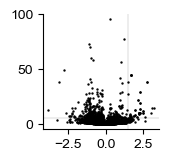

In [8]:

plt.figure(figsize=(1.5,1.5))
plt.scatter(df_din_psbs['beta'], -np.log10(df_din_psbs['pval']), s=0.5, c='black')
plt.scatter(df_din_psbs_sig['beta'], -np.log10(df_din_psbs_sig['pval']), s=0.5, c='black')

plt.axhline(-np.log10(0.05/len(df_din_psbs)), linewidth=0.1, c='black')
plt.axvline(1.5, linewidth=0.1, c='black')

plt.show()


35
3
21


/tmp/ipykernel_3401252/2011586083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins['motif'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[2])
/tmp/ipykernel_3401252/2011586083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins['motif'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[2])
/tmp/ipykernel_3401252/2011586083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

(<Figure size 150x150 with 1 Axes>, <Axes: ylabel='Proportion'>)

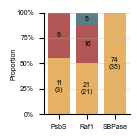

In [ ]:
df_din_sbpase_sig_with_type.loc[df_din_sbpase_sig_with_type.mut.str.contains('I', na=False)]

def get_unique_insertions(df):
    df_ins = df.loc[df.mut.str.contains('I', na=False)]
    df_ins['motif'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[2])

    m_list = []
    for m in df_ins['motif'].unique():
        if m not in m_list and nt.rev_complement(m) not in m_list   :
            m_list.append(m)
    return m_list

def plot_mutation_type_distribution(
    gene_data_dict,
    mutation_type_col='mutation_type',
    gene_names=None,
    colors=None,
    figsize=(8, 6),
    fontsize=12,
    title="Mutation Type Distribution by Gene",
    ylabel="Proportion",
    save_path=None
):
    """
    Create a normalized stacked barplot showing the distribution of mutation types for genes
    with absolute numbers displayed inside each segment.
    
    Parameters:
    -----------
    gene_data_dict : dict
        Dictionary with gene names as keys and DataFrames as values.
        Each DataFrame should contain a column with mutation types.
    mutation_type_col : str
        Column name containing mutation types ('insertion', 'deletion', 'substitution')
    gene_names : list, optional
        List of gene names to use as x-axis labels. If None, uses dictionary keys.
    colors : dict, optional
        Dictionary mapping mutation types to colors. If None, uses default colors.
    figsize : tuple
        Figure size (width, height)
    fontsize : int
        Font size for all text elements
    title : str
        Plot title
    ylabel : str
        Y-axis label
    save_path : str, optional
        Path to save the plot
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    
    Example:
    --------
    gene_data = {
        'Gene1': df1,
        'Gene2': df2, 
        'Gene3': df3
    }
    fig, ax = plot_mutation_type_distribution(gene_data, mutation_type_col='mut_type')
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    



    # Default colors for mutation types
    if colors is None:
        colors = {
            'insertion': '#e09f3e',     # Red
            'deletion': '#9e2a2b',      # Teal
            'substitution': '#335c67'   # Blue
        }
    
    # Use provided gene names or dictionary keys
    if gene_names is None:
        gene_names = list(gene_data_dict.keys())
    
    # Ensure we have exactly 3 genes
    if len(gene_names) != 3:
        raise ValueError("This function is designed for exactly 3 genes")
    
    # Calculate mutation type counts for each gene
    mutation_counts = {}
    mutation_types = ['insertion', 'deletion', 'substitution']
    
    dic_unique_ins_counts = {}
    for gene in gene_names:
        if gene not in gene_data_dict:
            raise ValueError(f"Gene '{gene}' not found in gene_data_dict")
        
        df = gene_data_dict[gene]
        
        # count how many unique motifs there are for the insertions
        unique_motif_list = get_unique_insertions(df)
        n_unique_motifs = len(unique_motif_list)
        dic_unique_ins_counts[gene] = n_unique_motifs

        if mutation_type_col not in df.columns:
            raise ValueError(f"Column '{mutation_type_col}' not found in DataFrame for gene '{gene}'")
        
        # Count each mutation type
        counts = df[mutation_type_col].value_counts()
        gene_counts = {}
        
        for mut_type in mutation_types:
            gene_counts[mut_type] = counts.get(mut_type, 0)
        
        mutation_counts[gene] = gene_counts
    
    # Convert to normalized proportions for plotting
    normalized_data = {}
    for gene in gene_names:
        total = sum(mutation_counts[gene].values())
        if total > 0:
            normalized_data[gene] = {
                mut_type: count / total for mut_type, count in mutation_counts[gene].items()
            }
        else:
            normalized_data[gene] = {mut_type: 0 for mut_type in mutation_types}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for stacked bar plot
    x_pos = np.arange(len(gene_names))
    bottoms = np.zeros(len(gene_names))
    
    # Plot each mutation type as a stack and add text labels
    for mut_type in mutation_types:
        proportions = [normalized_data[gene][mut_type] for gene in gene_names]
        absolute_counts = [mutation_counts[gene][mut_type] for gene in gene_names]
        unique_ins_counts = [dic_unique_ins_counts[gene] for gene in gene_names]

        # Create the bars
        bars = ax.bar(x_pos, proportions, bottom=bottoms, label=mut_type.capitalize(), 
                     color=colors[mut_type], alpha=0.8)
        
        # Add text labels with absolute counts inside each segment
        for i, (proportion, count) in enumerate(zip(proportions, absolute_counts)):
            if proportion > 0:  # Only add text if there's actually a segment
                # Calculate the center position of this segment
                text_y = bottoms[i] + proportion / 2
                
                text_to_display = str(count)
                if mut_type == 'insertion':
                    text_to_display = f'{str(count)}\n({unique_ins_counts[i]})'

                # Only show text if the segment is large enough (optional threshold)
                if proportion > 0.05:  # Only show if segment is > 5% of total
                    ax.text(x_pos[i], text_y, text_to_display, 
                           ha='center', va='center', 
                           fontsize=fontsize, fontweight='bold',
                           color='black')
        
        # Update bottoms for next stack
        bottoms += proportions
    
    # Customize the plot
    #ax.set_xlabel('Gene', fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize, labelpad=0)
    #ax.set_title(title, fontsize=fontsize + 2)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(gene_names, fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    
    # Add legend
    #ax.legend(fontsize=fontsize, loc='upper right')
    
    # Set y-axis to show proportions (0 to 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.savefig(save_path + '.svg', format='svg', bbox_inches='tight')
    
    return fig, ax

plot_mutation_type_distribution(gene_mutation_data, figsize=(1.5,1.5), fontsize=5, save_path = dout + 'fig4_distribution_type.png')

# comparing position of significant insertions

In [34]:

gene_to_df_sig_ins_all = {}
for gene_id, gene_n in [('3A', 'SBPase'), ('3B', 'Raf1'), ('3C', 'PsbS')]:

    # fetch the significant insertions
    df_sig = gene_mutation_data[gene_n]
    df_sig_ins = df_sig.loc[df_sig.mut.str.startswith('I', na=False)]
    df_sig_ins['motif'] = df_sig_ins.mut.apply(lambda x: nt.break_mut(x)[2])

    #fetch all mutant data
    df_din = pd.read_csv(din_lr + gene_id + '_sorghum_mean_lrr_lr.csv')
    df_all_inserts = df_din.loc[df_din.mut.str.startswith('I', na=False)]


    df_all_inserts['motif'] = df_all_inserts.mut.apply(lambda x: nt.break_mut(x)[2])
    df_all_inserts['pos'] = df_all_inserts.mut.apply(lambda x: nt.break_mut(x)[1])

    # get all the occurences of the significant motifs in the data.
    df_sig_ins_all = df_all_inserts.loc[df_all_inserts.motif.isin(df_sig_ins.motif)]
    df_sig_ins_all = df_sig_ins_all.loc[(df_sig_ins_all.pos > -151)&(df_sig_ins_all.pos < 51)]
    print(gene_n)
    print(max(df_sig_ins_all.pos))
    print(min(df_sig_ins_all.pos))
    print(df_sig_ins_all.shape)

    gene_to_df_sig_ins_all[gene_n] = df_sig_ins_all



SBPase
45
-145
(428, 15)
Raf1
40
-149
(85, 15)
PsbS
40
-145
(62, 15)


/tmp/ipykernel_2940053/857308231.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_inserts['motif'] = df_all_inserts.mut.apply(lambda x: nt.break_mut(x)[2])
/tmp/ipykernel_2940053/857308231.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_inserts['pos'] = df_all_inserts.mut.apply(lambda x: nt.break_mut(x)[1])
/tmp/ipykernel_2940053/857308231.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/tmp/ipykernel_2940053/1458378471.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')


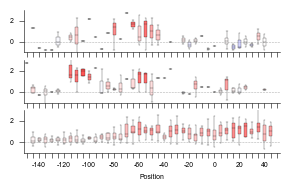

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

def create_multi_gene_boxplot(data_dict, step=5, window=2, vmax=None, linewidth=0.5):
    """
    Plot boxplots of insertion effects grouped by fixed 5bp windows around positions from -150 to +50.
    Boxes are colored based on median beta using the bwr colormap.
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary of gene -> DataFrame with 'pos' and 'beta'
    step : int
        Step size between center positions (default 5)
    window : int
        Half window size for binning (default ±2)
    vmax : float or None
        Max absolute beta value for colormap normalization
    linewidth : float
        Line width for all boxplot elements, axes, and ticks (default 0.5)
    """
    centers = np.arange(-150, 51, step)
    pos_labels = [str(c) for c in centers]

    # Collect medians for color normalization
    all_medians = []
    for df in data_dict.values():
        for center in centers:
            values = df[(df['pos'] >= center - window) & (df['pos'] <= center + window)]['beta'].values
            if len(values) > 0:
                all_medians.append(np.median(values))
    if vmax is None and all_medians:
        vmax = max(abs(np.min(all_medians)), abs(np.max(all_medians)))
    elif vmax is None:
        vmax = 1
    norm = Normalize(vmin=-vmax, vmax=vmax)
    cmap = cm.get_cmap('bwr')

    num_genes = len(data_dict)
    fig, axes = plt.subplots(nrows=num_genes, ncols=1, figsize=(3, 2), sharex=True)
    if num_genes == 1:
        axes = [axes]

    for ax, (gene, df) in zip(axes, data_dict.items()):
        df = df.copy()
        box_data = []
        medians = []
        for center in centers:
            values = df[(df['pos'] >= center - window) & (df['pos'] <= center + window)]['beta'].values
            box_data.append(values if len(values) > 0 else [])
            medians.append(np.median(values) if len(values) > 0 else 0.0)

        bp = ax.boxplot(
            box_data,
            positions=range(len(centers)),
            patch_artist=True,
            showfliers=False,
        )

        for i, patch in enumerate(bp['boxes']):
            patch.set_facecolor(cmap(norm(medians[i])))
            patch.set_alpha(0.9)
            patch.set_linewidth(linewidth)

        # Set linewidth and color for all boxplot elements
        for key in ['whiskers', 'caps']:
            for line in bp[key]:
                line.set_linewidth(linewidth)
        
        # Set median lines to black color and linewidth
        for line in bp['medians']:
            line.set_linewidth(linewidth)
            line.set_color('black')

        ax.axhline(0, color='gray', linestyle='--', alpha=0.6, linewidth=linewidth+0.2)
        ax.set_ylim(-1, 3)
        ax.set_yticks([0, 2])
        ax.set_yticklabels(['0', '2'], fontsize=5)
        #ax.set_title(gene, fontsize=5)
        ax.set_xticks(range(len(pos_labels)))
        ax.set_xticklabels([p if int(p) % 20 == 0 else '' for p in pos_labels], fontsize=5)
        ax.tick_params(axis='both', labelsize=5, width=linewidth+0.2)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        for spine in ['left', 'bottom']:
            ax.spines[spine].set_linewidth(linewidth+0.2)

    axes[-1].set_xlabel('Position', fontsize=5)
    plt.tight_layout(h_pad=0.2)
    plt.savefig(dout + 'fig5_boxplot.png', dpi=300)
    plt.savefig(dout + 'fig5_boxplot.svg', format='svg', bbox_inches='tight')

    plt.show()

gene_order = ['PsbS', 'Raf1', 'SBPase']
df_plot = dict(zip(gene_order, [gene_to_df_sig_ins_all[g] for g in gene_order]))
create_multi_gene_boxplot(df_plot, linewidth = 0.2)


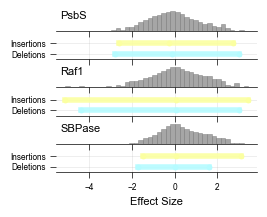

In [40]:
n_to_df = {
    'PsbS':df_din_psbs, 'Raf1':df_din_raf1, 'SBPase':df_din_sbpase
    }

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nucleotides as nt  # assuming this is your module

def create_mutation_range_plot(n_to_df, figsize=(8, 10), fontsize=10):
    """
    Create histogram and range plots showing beta value distributions and ranges 
    for deletions and insertions for each gene at positions >= -400.
    
    Parameters:
    -----------
    n_to_df : dict
        Dictionary of gene name -> DataFrame with 'mut' and 'beta' columns
    figsize : tuple
        Figure size (width, height)
    fontsize : int
        Font size for labels
    """
    
    # Prepare data
    gene_names = list(n_to_df.keys())
    n_genes = len(gene_names)
    
    # Colors for mutation types
    colors = {'deletion': '#b5fbff', 'insertion': '#fbffa1'}
    
    # First pass: collect all beta values to determine global range and bins
    all_beta_values = []
    for gene_name, df in n_to_df.items():
        # Add position column if not exists
        if 'pos' not in df.columns:
            df = df.copy()
            df['pos'] = df['mut'].apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)
        
        # Filter for positions >= -400 and remove NaN positions
        df_filtered = df[(df['pos'] >= -400) & df['pos'].notna()].copy()
        all_beta_values.extend(df_filtered['beta'].values)
    
    # Create consistent bins across all genes
    all_beta_values = np.array(all_beta_values)
    global_min = np.min(all_beta_values)
    global_max = np.max(all_beta_values)
    bin_edges = np.linspace(global_min, global_max, 41)  # 40 bins
    
    # Create 6 subplots (2 per gene) with more space
    fig, axes = plt.subplots(nrows=n_genes*2, ncols=1, figsize=figsize, sharex=True)
    if n_genes == 1:
        axes = [axes[0], axes[1]]
    
    for i, (gene_name, df) in enumerate(n_to_df.items()):
        hist_ax = axes[i*2]      # Histogram subplot
        range_ax = axes[i*2 + 1] # Range subplot
        
        # Add position column if not exists
        if 'pos' not in df.columns:
            df = df.copy()
            df['pos'] = df['mut'].apply(lambda x: nt.break_mut(x)[1] if x != 'wt' else np.nan)
        
        # Filter for positions >= -400 and remove NaN positions
        df_filtered = df[(df['pos'] >= -400) & df['pos'].notna()].copy()
        
        # Classify mutations
        df_filtered.loc[:, 'mutation_type'] = 'substitution'  # default
        df_filtered.loc[df_filtered['mut'].str.contains('_', na=False), 'mutation_type'] = 'deletion'
        df_filtered.loc[df_filtered['mut'].str.startswith('I', na=False), 'mutation_type'] = 'insertion'
        
        # Get data for each mutation type
        deletion_data = df_filtered[df_filtered['mutation_type'] == 'deletion']['beta']
        insertion_data = df_filtered[df_filtered['mutation_type'] == 'insertion']['beta']
        all_data = df_filtered['beta']
        
        deletion_count = len(deletion_data)
        insertion_count = len(insertion_data)
        
        # Plot histogram of ALL beta values with log scale using consistent bins
        if len(all_data) > 0:
            hist_ax.hist(all_data, bins=bin_edges, alpha=0.7, color='gray', 
                        density=True, label=f'All mutations (n={len(all_data)})', 
                        linewidth=0.5, edgecolor='gray')
        
        hist_ax.set_yscale('log')  # Set y-axis to log scale
        hist_ax.text(0.02, 0.95, f'{gene_name}', transform=hist_ax.transAxes, 
                    fontsize=fontsize+2, fontweight='bold', verticalalignment='top',
                    )
        #hist_ax.grid(False, alpha=0.3, linewidth=0.5)
        hist_ax.spines['top'].set_visible(False)
        hist_ax.spines['right'].set_visible(False)
        hist_ax.spines['left'].set_visible(False)
        hist_ax.spines['bottom'].set_linewidth(0.5)
        hist_ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=4)
        hist_ax.tick_params(axis='y', labelsize=fontsize, width=0, length=4)
        hist_ax.set_yticklabels([])
        
        # Plot range plot
        mutation_types = ['deletion', 'insertion']
        y_positions = [0, 1]
        
        for j, mut_type in enumerate(mutation_types):
            mut_data = df_filtered[df_filtered['mutation_type'] == mut_type]['beta']
            
            if len(mut_data) > 0:
                min_val = mut_data.min()
                max_val = mut_data.max()
                median_val = mut_data.median()
                
                # Plot range line (thicker linewidth)
                range_ax.plot([min_val, max_val], [y_positions[j], y_positions[j]], 
                            color=colors[mut_type], linewidth=4, alpha=0.9, zorder=10)
                
                # Plot min and max points (larger size)
                range_ax.scatter([min_val, max_val], [y_positions[j], y_positions[j]], 
                               color=colors[mut_type], s=10, zorder=11, linewidth=1)
                
                # Plot median point (larger size)
                range_ax.scatter(median_val, y_positions[j], 
                               color=colors[mut_type], s=10,  
                                linewidth=1, zorder=12,
                               label=f'{mut_type.capitalize()} (n={len(mut_data)})')
        
        # Customize range plot
        range_ax.set_yticks(y_positions)
        range_ax.set_yticklabels(['Deletions', 'Insertions'], fontsize=fontsize)
        range_ax.grid(True, alpha=0.3, linewidth=0.5)
        range_ax.spines['top'].set_visible(False)
        range_ax.spines['right'].set_visible(False)
        range_ax.spines['left'].set_visible(False)
        range_ax.spines['bottom'].set_linewidth(0.5)
        range_ax.set_ylim(-0.5, 1.5)
        range_ax.tick_params(axis='both', labelsize=fontsize, width=0.5, length=4)
    
    # Only set x-label for bottom plot
    axes[-1].set_xlabel('Effect Size', fontsize=fontsize+2, fontweight='bold')
    
    plt.tight_layout(pad=0.1)
    return fig, axes

#Usage example:
fig, axes = create_mutation_range_plot(n_to_df, figsize=(2.5,2), fontsize=6)
plt.savefig(dout + 'fig5_mutation_range.png', dpi=300)
plt.savefig(dout + 'fig5_mutation_range.svg', format='svg',dpi=300)

plt.show()

# k-mer enrichment in SBPase

In [24]:
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Set
import itertools
from scipy.stats import fisher_exact



def generate_all_submotifs(motifs: list, min_length: int = 2, max_length: int = None, ignore_direction: bool = False) -> Set[str]:
    """
    Generate all possible submotifs (subsequences) of a given motif.
    
    Parameters:
    -----------
    motif : str
        Input motif sequence
    min_length : int
        Minimum length of submotifs to consider (default: 2)
    max_length : int
        Maximum length of submotifs to consider (default: length of motif)
    
    Returns:
    --------
    Set[str] : Set of all unique submotifs
    """
    if max_length is None:
        max_length = len(motif)
    
    submotifs = list()
    for motif in motifs:
        for length in range(min_length, min(int(max_length) + 1, len(motif) + 1)):
            for start in range(len(motif) - length + 1):
                submotifs.append(motif[start:start + length])
    # filter out reverse complements

    if ignore_direction:
        submotifs_fwd = []
        for m in submotifs:
            rc = nt.rev_complement(m)
            # only make one submotif for both forward and reverse
            if m not in submotifs_fwd and rc not in submotifs_fwd:
                submotifs_fwd.append(m)
        submotifs = submotifs_fwd

    return list(set(submotifs))


def count_submotif_occurrences(motifs: List[str], submotif: str, case_sensitive: bool = True, ignore_direction: bool = False) -> int:
    """
    Count how many motifs contain the given submotif.
    
    Parameters:
    -----------
    motifs : List[str]
        List of motif sequences
    submotif : str
        Submotif to search for
    case_sensitive : bool
        Whether to perform case-sensitive search (default: True)
    
    Returns:
    --------
    int : Number of motifs containing the submotif
    """
    og_motifs_with_submotif = []
    search_submotif = submotif if case_sensitive else submotif.lower()
    
    for motif in motifs:
        if ignore_direction:
            motif_fwd = motif
            motif_rev = nt.rev_complement(motif)
            if search_submotif in motif_fwd or search_submotif in motif_rev:
                og_motifs_with_submotif.append(motif)
        else:
            if search_submotif in search_motif:
                og_motifs_with_submotif.append(motif)
            
    return og_motifs_with_submotif


def perform_fishers_exact_test(sig_with_motif, nonsig_with_motif, n_sig_motifs, n_nonsig_motifs):
    # Create 2x2 contingency table
    # [sig_with_motif, sig_without_motif]
    # [nonsig_with_motif, nonsig_without_motif]
    contingency_table = np.array([
        [sig_with_motif, n_sig_motifs - sig_with_motif],
        [nonsig_with_motif, n_nonsig_motifs - nonsig_with_motif]
    ])

    # Perform Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)
    return pd.Series({'OR':odds_ratio, 'pvalue': p_value})


In [70]:
# finding for each motif the max motif and only looking at the region that matters.
# sbpase: -70 to +40


def get_top_and_bottom_motifs(fin, max_effect_cutoff = 1, ins_pos_start=-400, ins_pos_end=200, min_length = 4, max_length = 30):
    # fetch all insertions within a certain region of interest, and split them based on an absolute cutoff into top and bottom
    df = pd.read_csv(din_lr + fin)

    df_ins = df.loc[df.mut.str.startswith('I')]
    df_ins['pos'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[1])
    df_ins['motif'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[2])
    df_ins_region = df_ins.loc[(df_ins.pos >=ins_pos_start)&(df_ins.pos <=ins_pos_end)]

    df_max_motif_region = df_ins_region.groupby('motif').max().sort_values(by='beta', ascending=False)
    print(df_ins_region.shape)
    print(df_max_motif_region.shape)

    # visualize the cutoff is ok
    plt.figure(figsize=(2,2))
    plt.hist(df_max_motif_region.beta, bins=100, color='black')
    plt.axvline(max_effect_cutoff, color = 'red', linestyle = '--')
    plt.show()

    # split the motifs into top and bottom
    top_motifs = list(set(df_max_motif_region.loc[df_max_motif_region.beta > max_effect_cutoff].index.tolist()))
    bottom_motifs = list(set(df_max_motif_region.loc[df_max_motif_region.beta < max_effect_cutoff].index.tolist()))
    print(len(top_motifs))
    print(len(bottom_motifs))

    # filter out motifs that are too short or too long
    top_motifs = [m for m in top_motifs if len(m) >= min_length and len(m) <= max_length]
    bottom_motifs = [m for m in bottom_motifs if len(m) >= min_length and len(m) <= max_length]
    all_motifs = list(set((top_motifs + bottom_motifs)))

    return top_motifs, bottom_motifs, all_motifs

def get_counts_top_bottom(top_motifs, bottom_motifs, all_motifs, min_length = 4, max_length = 20):
    # makes all the submotifs and determines their counts in the top and bottom motifs
    # then perform fisher's exact test to see if they are enriched for top or bottom
    # returns df_counts as a summary

    # generate submotifs
    all_submotifs = generate_all_submotifs(all_motifs, min_length=min_length, max_length=max_length, ignore_direction = True)
    print('num submotifs: ',len(all_submotifs))


    # calculate counts for each submotif in each of the top and bottom motifs, and store as a dataframe
    dic_submotif_top = dict(
        [
            (m,count_submotif_occurrences(top_motifs, m, case_sensitive=True, ignore_direction = True)) 
            for m in all_submotifs
            ]
            )
    dic_submotif_bottom = dict(
        [
            (m,count_submotif_occurrences(bottom_motifs, m, case_sensitive=True, ignore_direction = True)) 
            for m in all_submotifs
            ]
            )
    # convert to dataframe and merge
    df_top = pd.DataFrame(dic_submotif_top.items(), columns=['submotif', 'og_motifs_top'])
    df_bottom = pd.DataFrame(dic_submotif_bottom.items(), columns=['submotif', 'og_motifs_bottom'])
    df_counts = df_top.merge(df_bottom, on='submotif', how='inner')

    # add some relevant info
    df_counts['length'] = df_counts.submotif.apply(len)
    df_counts['top_counts'] = df_counts.og_motifs_top.apply(len) +1
    df_counts['bottom_counts'] = df_counts.og_motifs_bottom.apply(len) + 1


    ##### perform fisher's exact test
    # Calculate totals
    total_top = len(top_motifs)
    total_bottom = len(bottom_motifs)
    new_cols = df_counts.apply(
        lambda row: perform_fishers_exact_test(
            row['top_counts'], row['bottom_counts'], total_top, total_bottom), axis=1)

    df_counts = pd.concat([df_counts, new_cols], axis=1)
    df_counts.sort_values(by='OR', ascending=False, inplace=True)
    return df_counts

def plot_and_summarize_df_counts(df_counts):
    # plot volcano for enrichments, 
    # and return a OR/pvalue groupbied summary that groups indistinguishable submotifs together
    plt.figure(figsize=(2,2))
    plt.scatter(df_counts.OR, -np.log10(df_counts.pvalue), s=2, color = 'black')
    plt.axhline(y = -np.log10(0.05/len(df_counts)), color = 'red', linestyle = '--')
    plt.axvline(x = 10, color = 'blue', linestyle = '--')

    plt.show()

    # group them by OR and pvalue (ie no evidence to distinguish between them)
    df_counts_enrich = df_counts.loc[(df_counts.pvalue < 0.05/len(df_counts)) & (df_counts.OR > 10)]
    df_result = df_counts_enrich.groupby(['OR', 'pvalue'])['submotif'].apply(list)
    return df_result


/tmp/ipykernel_3401252/590545054.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins['pos'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[1])
/tmp/ipykernel_3401252/590545054.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins['motif'] = df_ins.mut.apply(lambda x: nt.break_mut(x)[2])


(1923, 15)
(555, 14)


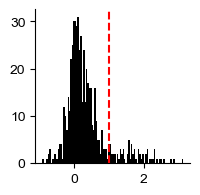

70
485
num submotifs:  5831


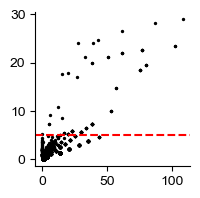

In [ ]:
# SBPase
fin = '3A_sorghum_mean_lrr_lr.csv'
# get a split of top and bottom motifs with max effect
top_motifs, bottom_motifs, all_motifs = get_top_and_bottom_motifs(fin, max_effect_cutoff = 1, ins_pos_start = -70, ins_pos_end = 40)
# calculate enrichment of submotifs
df_counts = get_counts_top_bottom(top_motifs, bottom_motifs, all_motifs)
# plot and summarize
df_result = plot_and_summarize_df_counts(df_counts)



In [63]:
df_sig = gene_mutation_data['SBPase']
df_sig_ins = df_sig.loc[df_sig.mut.str.contains('I', na=False)]
df_sig_ins['motif'] = df_sig_ins.mut.apply(lambda x: nt.break_mut(x)[2])
unique_rc_sig_motifs = []
for m in df_sig_ins.motif.unique():
    if nt.rev_complement(m) not in unique_rc_sig_motifs and m not in unique_rc_sig_motifs:
        unique_rc_sig_motifs.append(m)
print(len(unique_rc_sig_motifs))
print(len(df_sig_ins.motif.unique()))




35
44


In [65]:
print('total unique sig motifs:', len(unique_rc_sig_motifs))

top_submotif_containing_motifs = set([m for m in unique_rc_sig_motifs if (top_submotif in m) or (nt.rev_complement(top_submotif) in m)])
len_topsubmotif = len(top_submotif_containing_motifs)
print(f' {top_submotif} found in: {len_topsubmotif}')

second_submotif_containing_motifs = set([m for m in unique_rc_sig_motifs if (second_motif in m) or (nt.rev_complement(second_motif) in m)])

len_secondsubmotif = len(second_submotif_containing_motifs)
print(f' {second_motif} found in: {len_secondsubmotif}')

remaining_motifs = set(unique_rc_sig_motifs) - top_submotif_containing_motifs - second_submotif_containing_motifs
len_remaining = len(remaining_motifs)
print(f'remaining motifs: {len_remaining}')
for m in remaining_motifs:
    print(m, '-', nt.rev_complement(m))

total unique sig motifs: 35
 AGTCAA found in: 17
 GGATAA found in: 6
remaining motifs: 12
CTACACGTAAC - GTTACGTGTAG
CTTGTGCAACACGTAA - TTACGTGTTGCACAAG
TGGCGGTGGCGGCGGCGGTG - CACCGCCGCCGCCACCGCCA
ACACGTAACTT - AAGTTACGTGT
TGCCGTACGG - CCGTACGGCA
TATTACGGTTA - TAACCGTAATA
TAACACGCCACA - TGTGGCGTGTTA
CTTACACGTAA - TTACGTGTAAG
AGTTCCGTGTCC - GGACACGGAACT
AATGCTGACGTGGCA - TGCCACGTCAGCATT
ACTTGTGCAACACGTA - TACGTGTTGCACAAGT
GCAAGTGGC - GCCACTTGC


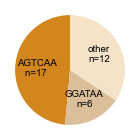

In [67]:
# Prepare data for pie chart
sizes = [len_topsubmotif, len_secondsubmotif, len_remaining]
labels = [f'{top_submotif}\nn={len_topsubmotif} ', 
            f'{second_motif}\nn={len_secondsubmotif}', 
            f'other\nn={len_remaining}']

# Define colors - grey for remaining, distinctive colors for the submotifs
colors = ['#d3851e',    # AGTCAA
          '#dbbf9a',    # GGATAA 
          '#f4e2c9']  # other

# Create the pie chart
fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Custom function to show absolute counts inside the pie
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'n={count}'
    return my_autopct

wedges, texts, autotexts = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    autopct=make_autopct(sizes),
    textprops={'fontsize': 5}
)

# Replace autotexts with custom label + count
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{labels[i]}")
    autotext.set_fontsize(7)
    autotext.set_ha('center')
    autotext.set_va('center')
    autotext.set_fontweight('normal')


# Customize the appearance
#ax.set_title('Distribution of Motif Categories in SBPase', fontsize=14, pad=20)

# Make percentage text bold
#for autotext in autotexts:
#    autotext.set_fontweight('bold')
    #autotext.set_color('white')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.tight_layout()

# Save the plot
plt.savefig(dout + 'motif_pie_chart.png', dpi=300, bbox_inches='tight')
plt.savefig(dout + 'motif_pie_chart.svg', bbox_inches='tight')

plt.show()